<a href="https://colab.research.google.com/github/Kirk-KD/caries-segmentation/blob/master/caries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import detectron2
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader, build_detection_test_loader, DatasetMapper
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
import matplotlib.pyplot as plt
from collections import Counter
import torch
import os
import random
import numpy as np
from PIL import Image
from detectron2.utils.visualizer import Visualizer
from torch.utils.data import WeightedRandomSampler
import json
import cv2

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-8xu9pioj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-8xu9pioj
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataset_root = "/content/drive/MyDrive/Colab Notebooks/Dental Caries Lesion Stages/caries-dataset"
class_names = ["caries-enamel", "caries-dentin", "caries-pulp"]
splits = ["train", "test", "valid"]

# Clean data

The original data contained some unused and garbled class names, which have already been removed manually. The following cell addresses the misalignment of the remaining class ID mapping.

Originally, the mapping was:
- 3 = dentin
- 4 = enamel
- 5 = pulp

For the sake of clarity, we will use the following code to generate `_annotations_clean.coco.json` in each of `train`, `valid`, and `test`, from `_annotations.coco.json`, with the new mapping:
- 1 = enamel
- 2 = dentin
- 3 = pulp

The new mapping will respect detectron2's expected ID range of `[1, #categories]`, and reflect the layers of tooth from the outside in.

This also means the annotation classes must be changed for each image too, with the following change map:
- 3 -> 2
- 4 -> 1
- 5 -> 3

In [3]:
change_map = {
    3: 2,
    4: 1,
    5: 3
}

for folder in splits:
    with open(f"{dataset_root}/{folder}/_annotations.coco.json", "r") as f:
        data = json.load(f)

    data["categories"] = [
        {
            "id": 1,
            "name": "caries-enamel",
            "supercategory": "caries-z1wh"
        },
        {
            "id": 2,
            "name": "caries-dentin",
            "supercategory": "caries-z1wh"
        },
        {
            "id": 3,
            "name": "caries-pulp",
            "supercategory": "caries-z1wh"
        }
    ]

    for ann in data["annotations"]:
        ann["category_id"] = change_map[ann["category_id"]]

    with open(f"{dataset_root}/{folder}/_annotations_clean.coco.json", "w") as f:
        json.dump(data, f)

After data is cleaned and remapped, we can now load from `_annotations_clean.coco.json` of each folder.

In [4]:
for folder in splits:
    register_coco_instances(folder, {}, f"{dataset_root}/{folder}/_annotations_clean.coco.json", f"{dataset_root}/{folder}")

# Config

In [5]:
# config
cfg = get_cfg()
YAML = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(YAML))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(YAML)
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("valid",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.DEVICE = "cuda"

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000
cfg.SOLVER.STEPS = [2000, 2500]
cfg.SOLVER.GAMMA = 0.5
cfg.TEST.EVAL_PERIOD = 300
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
cfg.INPUT.MIN_SIZE_TRAIN = (1000,)     # short side
cfg.INPUT.MAX_SIZE_TRAIN = 1500       # long side
cfg.INPUT.MIN_SIZE_TEST = 1000
cfg.INPUT.MAX_SIZE_TEST = 1500

# output
cfg.OUTPUT_DIR = "/content/caries-output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Exploration

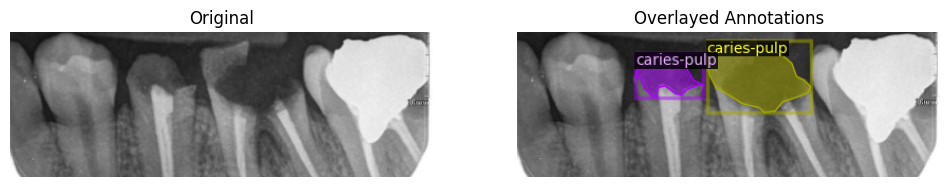

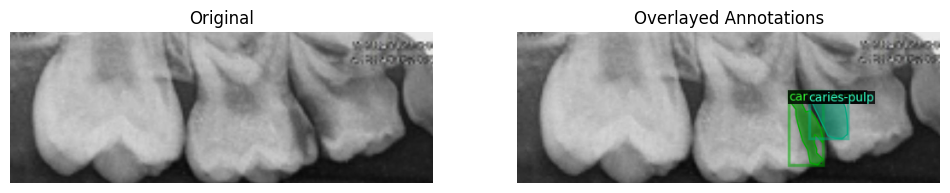

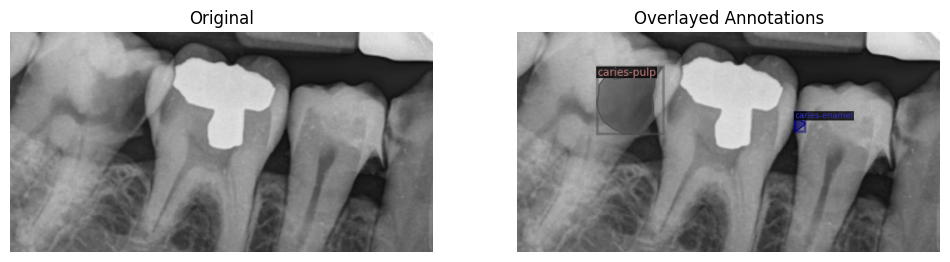

In [6]:
train_data = DatasetCatalog.get("train")
train_meta = MetadataCatalog.get("train")

for d in random.sample(train_data, 3):
    img = np.array(Image.open(d["file_name"]).convert("RGB"))

    visualizer = Visualizer(img, metadata=train_meta, scale=0.5)
    vis = visualizer.draw_dataset_dict(d).get_image()

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(img)
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(vis)
    ax[1].set_title("Overlayed Annotations")
    ax[1].axis("off")

    plt.show()

Number of training samples: 1217
Number of validation samples: 347
Number of evaluation samples: 152
Train frequencies:
caries-enamel: 0.43
caries-dentin: 0.50
caries-pulp: 0.07


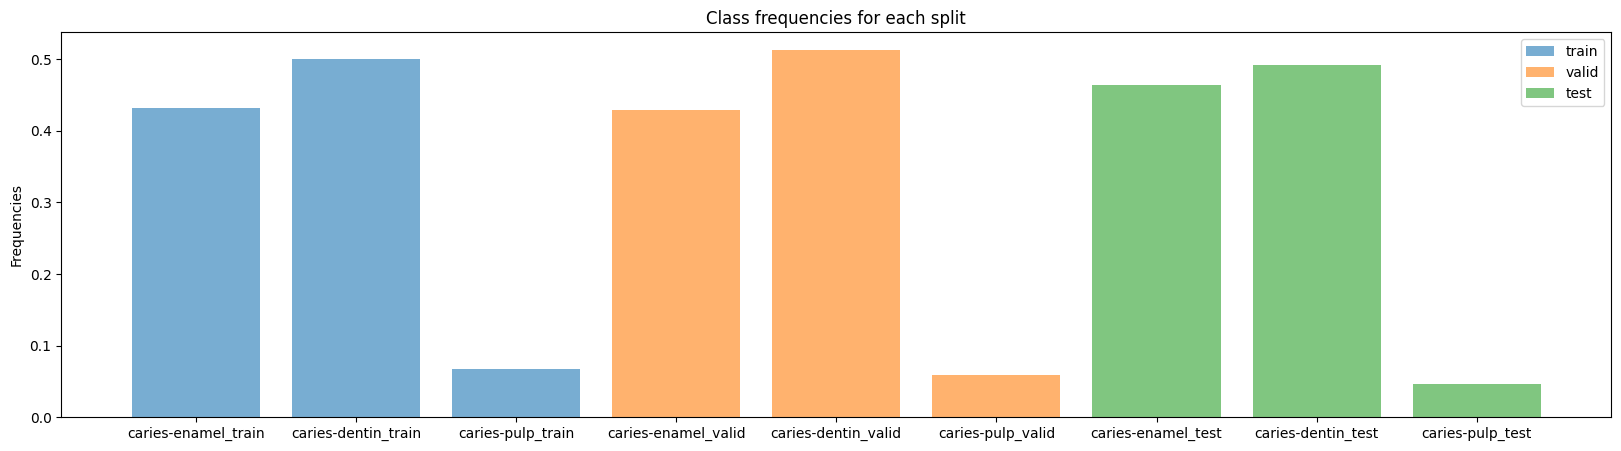

In [7]:
data_train = DatasetCatalog.get("train")  # training
data_valid = DatasetCatalog.get("valid")  # validation
data_test = DatasetCatalog.get("test")    # evaluation

print(f"Number of training samples: {len(data_train)}")
print(f"Number of validation samples: {len(data_valid)}")
print(f"Number of evaluation samples: {len(data_test)}")

def get_class_frequencies(dataset):
    counts = Counter()
    for item in dataset:
        for ann in item['annotations']:
            counts[ann['category_id']] += 1
    total = sum(counts.values())
    freqs = {k: v/total for k, v in counts.items()}
    return freqs

train_freqs = get_class_frequencies(data_train)
valid_freqs = get_class_frequencies(data_valid)
test_freqs  = get_class_frequencies(data_test)

classes = sorted(train_freqs.keys())
print("Train frequencies:")
for c in classes:
    print(f"{class_names[c]}: {train_freqs[c]:.2f}")

plt.figure(figsize=(20,5))
plt.bar([class_names[c]+'_train' for c in classes], [train_freqs[c] for c in classes], alpha=0.6, label='train')
plt.bar([class_names[c]+'_valid' for c in classes], [valid_freqs[c] for c in classes], alpha=0.6, label='valid')
plt.bar([class_names[c]+'_test' for c in classes], [test_freqs[c] for c in classes], alpha=0.6, label='test')
plt.ylabel("Frequencies")
plt.title("Class frequencies for each split")
plt.legend()
plt.show()

We notice severe class imbalance of `caries-pulp` (7%).

Width bin range: 6.559679999999999
Height bin range: 5.996


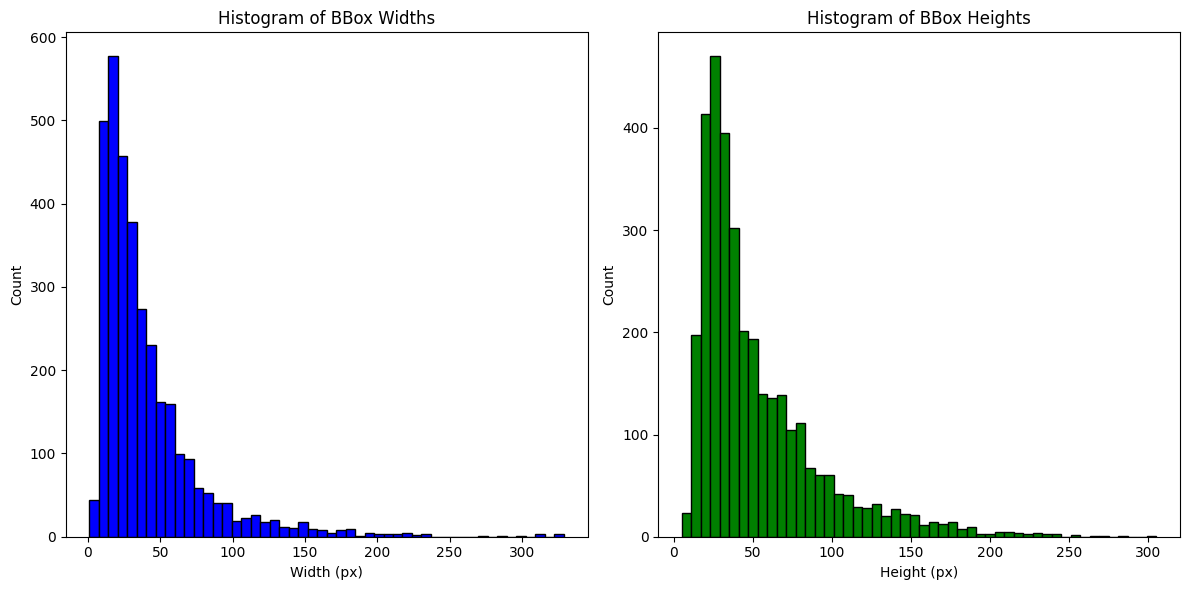

In [8]:
dataset_dicts = DatasetCatalog.get("train")

widths, heights = [], []
for d in dataset_dicts:
    for ann in d["annotations"]:
        x, y, w, h = ann["bbox"]
        widths.append(w)
        heights.append(h)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=50, color="blue", edgecolor="black")
plt.xlabel("Width (px)")
plt.ylabel("Count")
plt.title("Histogram of BBox Widths")

plt.subplot(1, 2, 2)
num_bins = 50
plt.hist(heights, bins=num_bins, color="green", edgecolor="black")
plt.xlabel("Height (px)")
plt.ylabel("Count")
plt.title("Histogram of BBox Heights")

width_range = (max(widths) - min(widths)) / num_bins
height_range = (max(heights) - min(heights)) / num_bins

print("Width bin range:", width_range)
print("Height bin range:", height_range)

plt.tight_layout()
plt.show()

BBox widths and heights both are right-skewed.

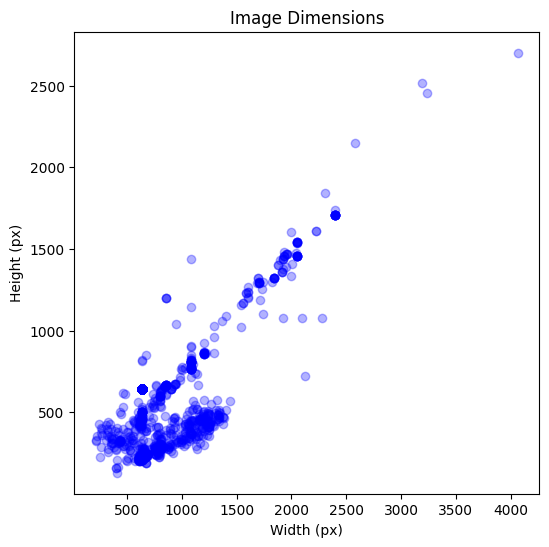

In [9]:
dataset_dicts = DatasetCatalog.get("train")

plt.figure(figsize=(6, 6))
for image in dataset_dicts:
    width = image["width"]
    height = image["height"]
    plt.plot(width, height, "bo", alpha=0.3)

plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.title("Image Dimensions")
plt.show()

Outliers may negatively influence training.

# Addressing class imbalance

Here we will use per-image oversampling by a factor of 5 for class `caries-pulp`.

In [14]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        data_train = DatasetCatalog.get("train")

        weights = []
        for d in data_train:
            cat_ids = [ann['category_id'] for ann in d['annotations']]
            weights.append(5.0 if 2 in cat_ids else 1.0)  # class index 2 = caries-pulp

        n_samples = cfg.SOLVER.IMS_PER_BATCH * cfg.SOLVER.MAX_ITER * 2  # times 2 for safety
        sampler = WeightedRandomSampler(weights, num_samples=n_samples, replacement=True)

        return build_detection_train_loader(cfg, sampler=sampler)

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

try:
  trainer = MyTrainer(cfg)
except RuntimeError:
  cfg.MODEL.DEVICE = "cpu"
  trainer = MyTrainer(cfg)

[09/14 19:14:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Check new class frequencies:

[09/14 19:04:12 d2.data.datasets.coco]: Loaded 1217 images in COCO format from /content/drive/MyDrive/Colab Notebooks/Dental Caries Lesion Stages/caries-dataset/train/_annotations_clean.coco.json
[09/14 19:04:12 d2.data.datasets.coco]: Loaded 1217 images in COCO format from /content/drive/MyDrive/Colab Notebooks/Dental Caries Lesion Stages/caries-dataset/train/_annotations_clean.coco.json
[09/14 19:04:12 d2.data.build]: Removed 0 images with no usable annotations. 1217 images left.
[09/14 19:04:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(1000,), max_size=1500, sample_style='choice'), RandomFlip()]
[09/14 19:04:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/14 19:04:12 d2.data.common]: Serializing 1217 elements to byte tensors and concatenating them all ...
[09/14 19:04:12 d2.data.common]: Serialized dataset takes 1.15 MiB
[09/14 19:04:12 d2.data.build]: M

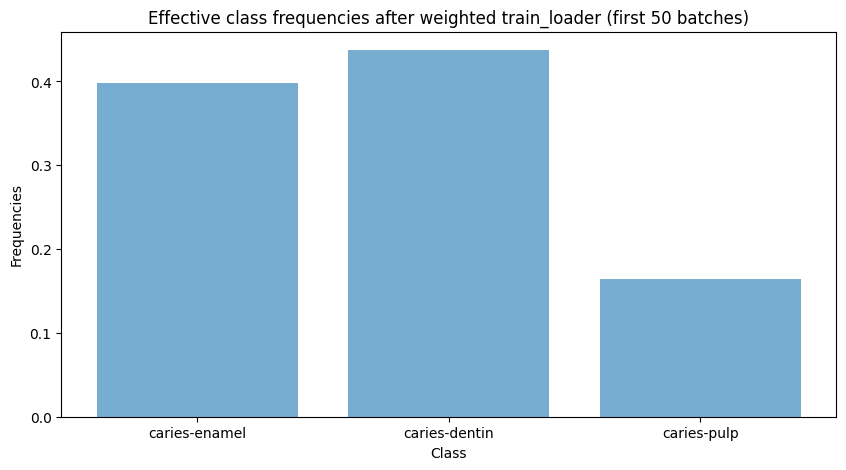

In [11]:
# count classes in the first N batches
counter = Counter()
N_batches = 50
for i, batch in enumerate(trainer.build_train_loader(cfg)):
    for sample in batch:
        anns = sample["instances"].gt_classes
        counter.update(anns.tolist())
    if i >= N_batches - 1:
        break

total = sum(counter.values())
classes = sorted(counter.keys())
frequencies = [counter[c]/total for c in classes]
print("Train frequencies:")
for c in classes:
    print(f"{class_names[c]}: {frequencies[c]:.2f}")

plt.figure(figsize=(10,5))
plt.bar([class_names[c] for c in classes], frequencies, alpha=0.6)
plt.ylabel("Frequencies")
plt.xlabel("Class")
plt.title(f"Effective class frequencies after weighted train_loader (first {N_batches} batches)")
plt.show()


After balancing, previously severely underrepresented class `caries-pulp` is resampled from around 7% to around 20%.

# Train

In [15]:
cfg.DATASETS.TEST = ("valid",)
trainer.resume_or_load(resume=False)
trainer.train()

[09/14 19:14:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[09/14 19:14:24 d2.engine.train_loop]: Starting training from iteration 0
[09/14 19:14:52 d2.utils.events]:  eta: 1:07:43  iter: 19  total_loss: 2.768  loss_cls: 1.569  loss_box_reg: 0.09959  loss_mask: 0.6933  loss_rpn_cls: 0.4036  loss_rpn_loc: 0.03127    time: 1.2937  last_time: 1.4720  data_time: 0.1100  last_data_time: 0.0234   lr: 4.9953e-06  max_mem: 7339M
[09/14 19:15:18 d2.utils.events]:  eta: 1:09:32  iter: 39  total_loss: 2.677  loss_cls: 1.375  loss_box_reg: 0.1369  loss_mask: 0.693  loss_rpn_cls: 0.3858  loss_rpn_loc: 0.02867    time: 1.2988  last_time: 0.9353  data_time: 0.0312  last_data_time: 0.0305   lr: 9.9902e-06  max_mem: 7339M
[09/14 19:15:44 d2.utils.events]:  eta: 1:09:57  iter: 59  total_loss: 2.387  loss_cls: 1.074  loss_box_reg: 0.1332  loss_mask: 0.692  loss_rpn_cls: 0.3862  loss_rpn_loc: 0.033    time: 1.2958  last_time: 1.4674  data_time: 0.0311  last_data_time: 0.0471   lr: 1.4985e-05  max_mem: 7339M
[09/14 19:16:09 d2.utils.events]:  eta: 1:09:06  iter: 7

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 19:20:59 d2.evaluation.evaluator]: Inference done 11/347. Dataloading: 0.0014 s/iter. Inference: 0.1620 s/iter. Eval: 0.2314 s/iter. Total: 0.3948 s/iter. ETA=0:02:12
[09/14 19:21:04 d2.evaluation.evaluator]: Inference done 28/347. Dataloading: 0.0023 s/iter. Inference: 0.1554 s/iter. Eval: 0.1660 s/iter. Total: 0.3239 s/iter. ETA=0:01:43
[09/14 19:21:09 d2.evaluation.evaluator]: Inference done 42/347. Dataloading: 0.0028 s/iter. Inference: 0.1523 s/iter. Eval: 0.1830 s/iter. Total: 0.3384 s/iter. ETA=0:01:43
[09/14 19:21:15 d2.evaluation.evaluator]: Inference done 50/347. Dataloading: 0.0028 s/iter. Inference: 0.1580 s/iter. Eval: 0.2380 s/iter. Total: 0.3991 s/iter. ETA=0:01:58
[09/14 19:21:21 d2.evaluation.evaluator]: Inference done 61/347. Dataloading: 0.0029 s/iter. Inference: 0.1588 s/iter. Eval: 0.2635 s/iter. Total: 0.4254 s/iter. ETA=0:02:01
[09/14 19:21:27 d2.evaluation.evaluator]: Inference done 76/347. Dataloading: 0.0028 s/iter. Inference: 0.1602 s/iter. Eval: 0.257

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 19:29:39 d2.evaluation.evaluator]: Inference done 11/347. Dataloading: 0.0011 s/iter. Inference: 0.1605 s/iter. Eval: 0.2030 s/iter. Total: 0.3646 s/iter. ETA=0:02:02
[09/14 19:29:44 d2.evaluation.evaluator]: Inference done 30/347. Dataloading: 0.0019 s/iter. Inference: 0.1522 s/iter. Eval: 0.1343 s/iter. Total: 0.2885 s/iter. ETA=0:01:31
[09/14 19:29:50 d2.evaluation.evaluator]: Inference done 43/347. Dataloading: 0.0020 s/iter. Inference: 0.1537 s/iter. Eval: 0.1855 s/iter. Total: 0.3413 s/iter. ETA=0:01:43
[09/14 19:29:55 d2.evaluation.evaluator]: Inference done 53/347. Dataloading: 0.0022 s/iter. Inference: 0.1577 s/iter. Eval: 0.2190 s/iter. Total: 0.3790 s/iter. ETA=0:01:51
[09/14 19:30:01 d2.evaluation.evaluator]: Inference done 66/347. Dataloading: 0.0024 s/iter. Inference: 0.1565 s/iter. Eval: 0.2253 s/iter. Total: 0.3843 s/iter. ETA=0:01:47
[09/14 19:30:06 d2.evaluation.evaluator]: Inference done 77/347. Dataloading: 0.0026 s/iter. Inference: 0.1582 s/iter. Eval: 0.235

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 19:38:16 d2.evaluation.evaluator]: Inference done 11/347. Dataloading: 0.0011 s/iter. Inference: 0.1515 s/iter. Eval: 0.1780 s/iter. Total: 0.3305 s/iter. ETA=0:01:51
[09/14 19:38:21 d2.evaluation.evaluator]: Inference done 30/347. Dataloading: 0.0032 s/iter. Inference: 0.1485 s/iter. Eval: 0.1276 s/iter. Total: 0.2794 s/iter. ETA=0:01:28
[09/14 19:38:28 d2.evaluation.evaluator]: Inference done 48/347. Dataloading: 0.0027 s/iter. Inference: 0.1482 s/iter. Eval: 0.1653 s/iter. Total: 0.3165 s/iter. ETA=0:01:34
[09/14 19:38:33 d2.evaluation.evaluator]: Inference done 61/347. Dataloading: 0.0028 s/iter. Inference: 0.1493 s/iter. Eval: 0.1868 s/iter. Total: 0.3390 s/iter. ETA=0:01:36
[09/14 19:38:38 d2.evaluation.evaluator]: Inference done 77/347. Dataloading: 0.0029 s/iter. Inference: 0.1493 s/iter. Eval: 0.1815 s/iter. Total: 0.3339 s/iter. ETA=0:01:30
[09/14 19:38:43 d2.evaluation.evaluator]: Inference done 102/347. Dataloading: 0.0028 s/iter. Inference: 0.1432 s/iter. Eval: 0.15

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 19:46:40 d2.evaluation.evaluator]: Inference done 11/347. Dataloading: 0.0011 s/iter. Inference: 0.1493 s/iter. Eval: 0.1604 s/iter. Total: 0.3108 s/iter. ETA=0:01:44
[09/14 19:46:46 d2.evaluation.evaluator]: Inference done 34/347. Dataloading: 0.0024 s/iter. Inference: 0.1411 s/iter. Eval: 0.1028 s/iter. Total: 0.2465 s/iter. ETA=0:01:17
[09/14 19:46:52 d2.evaluation.evaluator]: Inference done 48/347. Dataloading: 0.0033 s/iter. Inference: 0.1469 s/iter. Eval: 0.1645 s/iter. Total: 0.3150 s/iter. ETA=0:01:34
[09/14 19:46:57 d2.evaluation.evaluator]: Inference done 62/347. Dataloading: 0.0030 s/iter. Inference: 0.1474 s/iter. Eval: 0.1748 s/iter. Total: 0.3254 s/iter. ETA=0:01:32
[09/14 19:47:02 d2.evaluation.evaluator]: Inference done 78/347. Dataloading: 0.0034 s/iter. Inference: 0.1474 s/iter. Eval: 0.1728 s/iter. Total: 0.3238 s/iter. ETA=0:01:27
[09/14 19:47:07 d2.evaluation.evaluator]: Inference done 101/347. Dataloading: 0.0039 s/iter. Inference: 0.1423 s/iter. Eval: 0.15

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 19:54:55 d2.evaluation.evaluator]: Inference done 11/347. Dataloading: 0.0011 s/iter. Inference: 0.1395 s/iter. Eval: 0.1033 s/iter. Total: 0.2439 s/iter. ETA=0:01:21
[09/14 19:55:00 d2.evaluation.evaluator]: Inference done 39/347. Dataloading: 0.0024 s/iter. Inference: 0.1341 s/iter. Eval: 0.0610 s/iter. Total: 0.1977 s/iter. ETA=0:01:00
[09/14 19:55:05 d2.evaluation.evaluator]: Inference done 55/347. Dataloading: 0.0025 s/iter. Inference: 0.1386 s/iter. Eval: 0.0957 s/iter. Total: 0.2369 s/iter. ETA=0:01:09
[09/14 19:55:10 d2.evaluation.evaluator]: Inference done 72/347. Dataloading: 0.0025 s/iter. Inference: 0.1378 s/iter. Eval: 0.1119 s/iter. Total: 0.2524 s/iter. ETA=0:01:09
[09/14 19:55:15 d2.evaluation.evaluator]: Inference done 102/347. Dataloading: 0.0024 s/iter. Inference: 0.1333 s/iter. Eval: 0.0925 s/iter. Total: 0.2284 s/iter. ETA=0:00:55
[09/14 19:55:21 d2.evaluation.evaluator]: Inference done 126/347. Dataloading: 0.0026 s/iter. Inference: 0.1349 s/iter. Eval: 0.0

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 20:02:52 d2.evaluation.evaluator]: Inference done 11/347. Dataloading: 0.0011 s/iter. Inference: 0.1340 s/iter. Eval: 0.0647 s/iter. Total: 0.1998 s/iter. ETA=0:01:07
[09/14 20:02:57 d2.evaluation.evaluator]: Inference done 43/347. Dataloading: 0.0019 s/iter. Inference: 0.1285 s/iter. Eval: 0.0425 s/iter. Total: 0.1731 s/iter. ETA=0:00:52
[09/14 20:03:03 d2.evaluation.evaluator]: Inference done 61/347. Dataloading: 0.0033 s/iter. Inference: 0.1351 s/iter. Eval: 0.0841 s/iter. Total: 0.2225 s/iter. ETA=0:01:03
[09/14 20:03:08 d2.evaluation.evaluator]: Inference done 89/347. Dataloading: 0.0031 s/iter. Inference: 0.1321 s/iter. Eval: 0.0729 s/iter. Total: 0.2083 s/iter. ETA=0:00:53
[09/14 20:03:13 d2.evaluation.evaluator]: Inference done 122/347. Dataloading: 0.0028 s/iter. Inference: 0.1297 s/iter. Eval: 0.0600 s/iter. Total: 0.1927 s/iter. ETA=0:00:43
[09/14 20:03:18 d2.evaluation.evaluator]: Inference done 147/347. Dataloading: 0.0032 s/iter. Inference: 0.1304 s/iter. Eval: 0.0

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 20:10:28 d2.evaluation.evaluator]: Inference done 11/347. Dataloading: 0.0011 s/iter. Inference: 0.1387 s/iter. Eval: 0.0999 s/iter. Total: 0.2398 s/iter. ETA=0:01:20
[09/14 20:10:34 d2.evaluation.evaluator]: Inference done 39/347. Dataloading: 0.0020 s/iter. Inference: 0.1319 s/iter. Eval: 0.0595 s/iter. Total: 0.1934 s/iter. ETA=0:00:59
[09/14 20:10:39 d2.evaluation.evaluator]: Inference done 53/347. Dataloading: 0.0024 s/iter. Inference: 0.1393 s/iter. Eval: 0.1040 s/iter. Total: 0.2458 s/iter. ETA=0:01:12
[09/14 20:10:44 d2.evaluation.evaluator]: Inference done 72/347. Dataloading: 0.0023 s/iter. Inference: 0.1372 s/iter. Eval: 0.1113 s/iter. Total: 0.2510 s/iter. ETA=0:01:09
[09/14 20:10:49 d2.evaluation.evaluator]: Inference done 100/347. Dataloading: 0.0024 s/iter. Inference: 0.1328 s/iter. Eval: 0.0945 s/iter. Total: 0.2298 s/iter. ETA=0:00:56
[09/14 20:10:54 d2.evaluation.evaluator]: Inference done 120/347. Dataloading: 0.0035 s/iter. Inference: 0.1357 s/iter. Eval: 0.0

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 20:18:29 d2.evaluation.evaluator]: Inference done 11/347. Dataloading: 0.0011 s/iter. Inference: 0.1334 s/iter. Eval: 0.0640 s/iter. Total: 0.1985 s/iter. ETA=0:01:06
[09/14 20:18:34 d2.evaluation.evaluator]: Inference done 40/347. Dataloading: 0.0024 s/iter. Inference: 0.1319 s/iter. Eval: 0.0488 s/iter. Total: 0.1832 s/iter. ETA=0:00:56
[09/14 20:18:39 d2.evaluation.evaluator]: Inference done 56/347. Dataloading: 0.0039 s/iter. Inference: 0.1386 s/iter. Eval: 0.0818 s/iter. Total: 0.2244 s/iter. ETA=0:01:05
[09/14 20:18:44 d2.evaluation.evaluator]: Inference done 80/347. Dataloading: 0.0034 s/iter. Inference: 0.1362 s/iter. Eval: 0.0812 s/iter. Total: 0.2210 s/iter. ETA=0:00:58
[09/14 20:18:50 d2.evaluation.evaluator]: Inference done 114/347. Dataloading: 0.0031 s/iter. Inference: 0.1315 s/iter. Eval: 0.0651 s/iter. Total: 0.1998 s/iter. ETA=0:00:46
[09/14 20:18:55 d2.evaluation.evaluator]: Inference done 133/347. Dataloading: 0.0031 s/iter. Inference: 0.1339 s/iter. Eval: 0.0

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 20:26:14 d2.evaluation.evaluator]: Inference done 11/347. Dataloading: 0.0025 s/iter. Inference: 0.1383 s/iter. Eval: 0.1058 s/iter. Total: 0.2467 s/iter. ETA=0:01:22
[09/14 20:26:19 d2.evaluation.evaluator]: Inference done 39/347. Dataloading: 0.0049 s/iter. Inference: 0.1335 s/iter. Eval: 0.0563 s/iter. Total: 0.1948 s/iter. ETA=0:00:59
[09/14 20:26:25 d2.evaluation.evaluator]: Inference done 61/347. Dataloading: 0.0042 s/iter. Inference: 0.1361 s/iter. Eval: 0.0855 s/iter. Total: 0.2262 s/iter. ETA=0:01:04
[09/14 20:26:30 d2.evaluation.evaluator]: Inference done 90/347. Dataloading: 0.0044 s/iter. Inference: 0.1320 s/iter. Eval: 0.0726 s/iter. Total: 0.2093 s/iter. ETA=0:00:53
[09/14 20:26:35 d2.evaluation.evaluator]: Inference done 123/347. Dataloading: 0.0037 s/iter. Inference: 0.1299 s/iter. Eval: 0.0603 s/iter. Total: 0.1942 s/iter. ETA=0:00:43
[09/14 20:26:40 d2.evaluation.evaluator]: Inference done 146/347. Dataloading: 0.0037 s/iter. Inference: 0.1310 s/iter. Eval: 0.0

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 20:34:09 d2.evaluation.evaluator]: Inference done 11/347. Dataloading: 0.0009 s/iter. Inference: 0.1328 s/iter. Eval: 0.0669 s/iter. Total: 0.2006 s/iter. ETA=0:01:07
[09/14 20:34:14 d2.evaluation.evaluator]: Inference done 40/347. Dataloading: 0.0051 s/iter. Inference: 0.1315 s/iter. Eval: 0.0452 s/iter. Total: 0.1819 s/iter. ETA=0:00:55
[09/14 20:34:20 d2.evaluation.evaluator]: Inference done 61/347. Dataloading: 0.0040 s/iter. Inference: 0.1343 s/iter. Eval: 0.0737 s/iter. Total: 0.2123 s/iter. ETA=0:01:00
[09/14 20:34:25 d2.evaluation.evaluator]: Inference done 95/347. Dataloading: 0.0032 s/iter. Inference: 0.1284 s/iter. Eval: 0.0570 s/iter. Total: 0.1889 s/iter. ETA=0:00:47
[09/14 20:34:30 d2.evaluation.evaluator]: Inference done 124/347. Dataloading: 0.0035 s/iter. Inference: 0.1293 s/iter. Eval: 0.0527 s/iter. Total: 0.1858 s/iter. ETA=0:00:41
[09/14 20:34:35 d2.evaluation.evaluator]: Inference done 151/347. Dataloading: 0.0032 s/iter. Inference: 0.1302 s/iter. Eval: 0.0

# Evaluation

In [16]:
cfg.DATASETS.TEST = ("test",)
evaluator = COCOEvaluator("test", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "test")
metrics = inference_on_dataset(trainer.model, val_loader, evaluator)

metrics

WARNING [09/14 20:35:18 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[09/14 20:35:18 d2.data.datasets.coco]: Loaded 152 images in COCO format from /content/drive/MyDrive/Colab Notebooks/Dental Caries Lesion Stages/caries-dataset/test/_annotations_clean.coco.json
[09/14 20:35:18 d2.data.build]: Distribution of instances among all 3 categories:
|   category    | #instances   |   category    | #instances   |  category   | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-----------:|:-------------|
| caries-enamel | 182          | caries-dentin | 193          | caries-pulp | 18           |
|               |              |               |              |             |              |
|     total     | 393          |               |              |             |              |
[09/14 20:35:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference:

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[09/14 20:35:23 d2.evaluation.evaluator]: Inference done 11/152. Dataloading: 0.1036 s/iter. Inference: 0.1406 s/iter. Eval: 0.1731 s/iter. Total: 0.4173 s/iter. ETA=0:00:58
[09/14 20:35:28 d2.evaluation.evaluator]: Inference done 25/152. Dataloading: 0.0355 s/iter. Inference: 0.1551 s/iter. Eval: 0.1872 s/iter. Total: 0.3784 s/iter. ETA=0:00:48
[09/14 20:35:33 d2.evaluation.evaluator]: Inference done 50/152. Dataloading: 0.0480 s/iter. Inference: 0.1368 s/iter. Eval: 0.0951 s/iter. Total: 0.2803 s/iter. ETA=0:00:28
[09/14 20:35:39 d2.evaluation.evaluator]: Inference done 68/152. Dataloading: 0.0520 s/iter. Inference: 0.1397 s/iter. Eval: 0.0969 s/iter. Total: 0.2889 s/iter. ETA=0:00:24
[09/14 20:35:44 d2.evaluation.evaluator]: Inference done 93/152. Dataloading: 0.0483 s/iter. Inference: 0.1357 s/iter. Eval: 0.0793 s/iter. Total: 0.2637 s/iter. ETA=0:00:15
[09/14 20:35:49 d2.evaluation.evaluator]: Inference done 119/152. Dataloading: 0.0469 s/iter. Inference: 0.1341 s/iter. Eval: 0.06

OrderedDict([('bbox',
              {'AP': 22.56117220759496,
               'AP50': 51.05384389548544,
               'AP75': 14.649052228881809,
               'APs': 15.764551021145277,
               'APm': 24.37816700184166,
               'APl': 22.720044801544855,
               'AP-caries-enamel': 15.50101813026234,
               'AP-caries-dentin': 24.50645387771204,
               'AP-caries-pulp': 27.676044614810497}),
             ('segm',
              {'AP': 21.306465060448442,
               'AP50': 48.252537401527185,
               'AP75': 13.593761859977576,
               'APs': 12.024581120314823,
               'APm': 20.57620008030609,
               'APl': 32.21919170333834,
               'AP-caries-enamel': 13.4470991941182,
               'AP-caries-dentin': 19.534448390141577,
               'AP-caries-pulp': 30.93784759708555})])

Plot some graphs

dict_keys(['rpn/num_pos_anchors', 'rpn/num_neg_anchors', 'roi_head/num_fg_samples', 'roi_head/num_bg_samples', 'fast_rcnn/cls_accuracy', 'fast_rcnn/fg_cls_accuracy', 'fast_rcnn/false_negative', 'mask_rcnn/accuracy', 'mask_rcnn/false_positive', 'mask_rcnn/false_negative', 'rank_data_time', 'data_time', 'total_loss', 'loss_cls', 'loss_box_reg', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc', 'lr', 'time', 'eta_seconds', 'bbox/AP', 'bbox/AP50', 'bbox/AP75', 'bbox/APs', 'bbox/APm', 'bbox/APl', 'bbox/AP-caries-enamel', 'bbox/AP-caries-dentin', 'bbox/AP-caries-pulp', 'segm/AP', 'segm/AP50', 'segm/AP75', 'segm/APs', 'segm/APm', 'segm/APl', 'segm/AP-caries-enamel', 'segm/AP-caries-dentin', 'segm/AP-caries-pulp'])


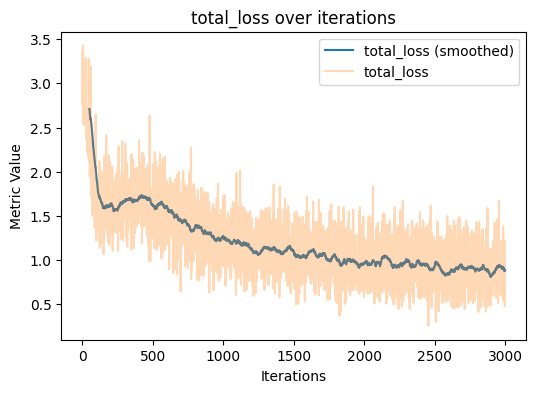

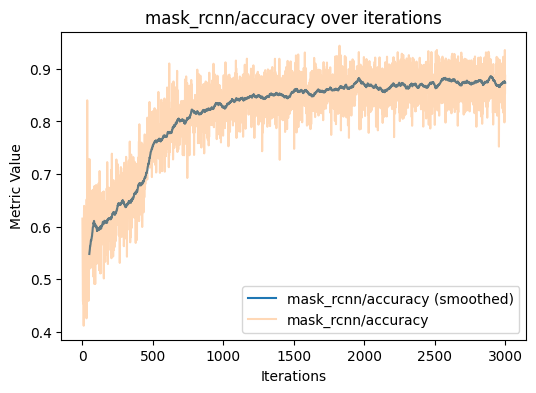

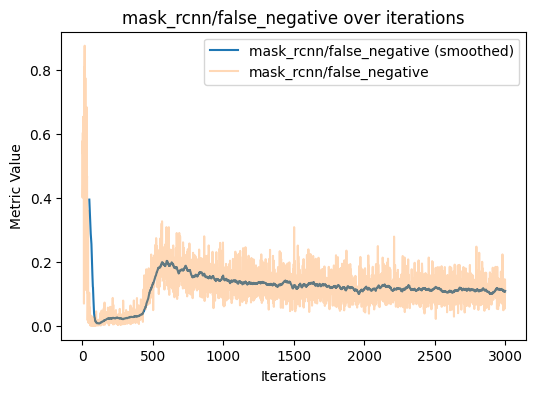

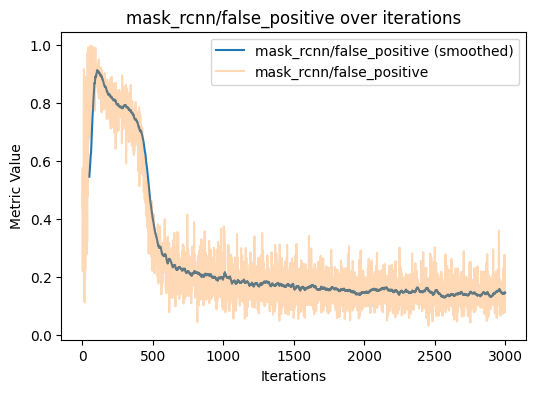

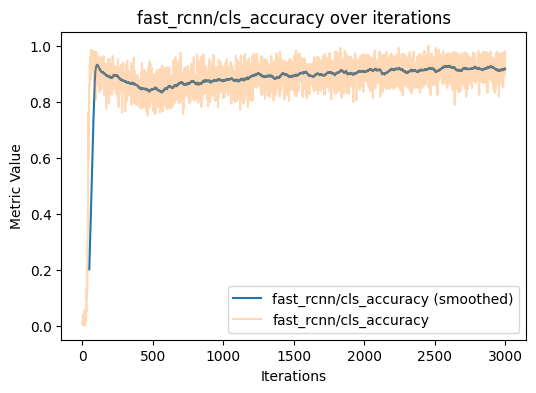

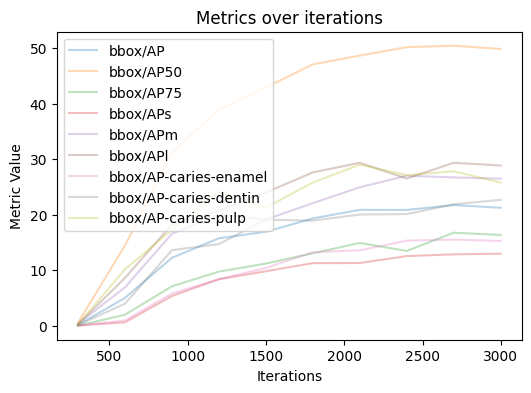

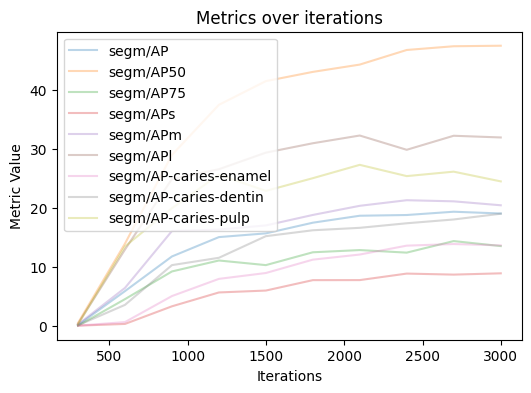

In [20]:
def plot_metric(metric_names, window=50):
    if isinstance(metric_names, str):
        metric_names = [metric_names]  # wrap single metric in list

    plt.figure(figsize=(6, 4))

    for metric_name in metric_names:
        metrics = []
        iters = []

        for event in trainer.storage.history(metric_name).values():
            iters.append(event[1])
            metrics.append(event[0])

        # smoothing
        if len(metrics) >= window:
            smooth_metric = np.convolve(metrics, np.ones(window)/window, mode='valid')
            plt.plot(iters[window-1:], smooth_metric, label=f"{metric_name} (smoothed)")

        plt.plot(iters, metrics, alpha=0.3, label=f"{metric_name}")

    plt.xlabel("Iterations")
    plt.ylabel("Metric Value")
    if len(metric_names) == 1:
        plt.title(f"{metric_names[0]} over iterations")
    else:
        plt.title("Metrics over iterations")
    plt.legend()
    plt.show()

print(trainer.storage.histories().keys())

plot_metric("total_loss")
plot_metric("mask_rcnn/accuracy")
plot_metric("mask_rcnn/false_negative")
plot_metric("mask_rcnn/false_positive")
plot_metric("fast_rcnn/cls_accuracy")
plot_metric(['bbox/AP', 'bbox/AP50', 'bbox/AP75', 'bbox/APs', 'bbox/APm', 'bbox/APl', 'bbox/AP-caries-enamel', 'bbox/AP-caries-dentin', 'bbox/AP-caries-pulp'])
plot_metric(['segm/AP', 'segm/AP50', 'segm/AP75', 'segm/APs', 'segm/APm', 'segm/APl', 'segm/AP-caries-enamel', 'segm/AP-caries-dentin', 'segm/AP-caries-pulp'])

Visualize model inference

[09/14 20:47:21 d2.data.datasets.coco]: Loaded 152 images in COCO format from /content/drive/MyDrive/Colab Notebooks/Dental Caries Lesion Stages/caries-dataset/test/_annotations_clean.coco.json


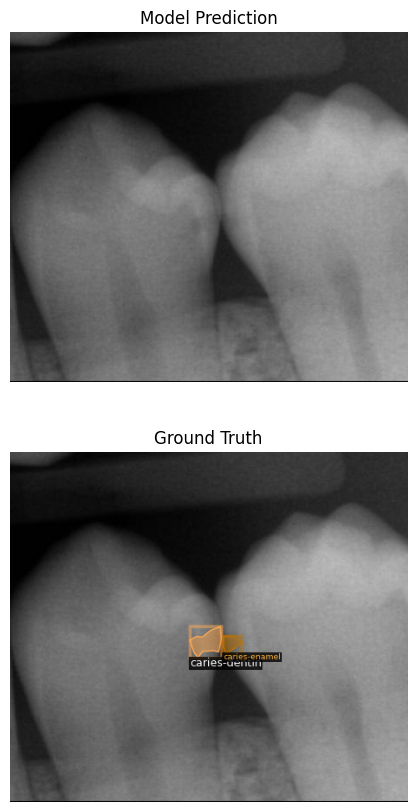

In [26]:
model = trainer.model
model.eval()

test_data = DatasetCatalog.get("test")
test_meta = MetadataCatalog.get("test")
img_dict = random.choice(test_data)
img = cv2.imread(img_dict["file_name"])

with torch.no_grad():
    outputs = model([{"image": torch.as_tensor(img.transpose(2, 0, 1))}])

v_pred = Visualizer(img[:, :, ::-1], metadata=test_meta, scale=1.0)
instances = outputs[0]["instances"]
instances = instances[instances.scores > 0.5]
out_pred = v_pred.draw_instance_predictions(instances.to("cpu"))
pred_img = out_pred.get_image()[:, :, ::-1]

v_gt = Visualizer(img[:, :, ::-1], metadata=test_meta, scale=1.0)
out_gt = v_gt.draw_dataset_dict(img_dict)
gt_img = out_gt.get_image()[:, :, ::-1]

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.imshow(pred_img)
plt.title("Model Prediction")
plt.axis("off")
plt.subplot(2, 1, 2)
plt.imshow(gt_img)
plt.title("Ground Truth")
plt.axis("off")
plt.show()